<a href="https://colab.research.google.com/github/chakra17/DiabetesApp/blob/main/trained_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) Paths, readers, and Data Preparation (NHANES + PhysioNet → dataset)

In [ ]:
# --- Mount Drive ---
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- Install deps (once per runtime) ---
!pip install -q pandas numpy scikit-learn imbalanced-learn shap joblib matplotlib


In [ ]:
# intial paths
from pathlib import Path
import numpy as np
import pandas as pd

In [ ]:
#configuration
PROJECT_ROOT = Path("/content/drive/MyDrive/Project")
OUT_DIR      = PROJECT_ROOT / "data"
MODELS_DIR   = PROJECT_ROOT / "models"
OUT_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:

# Flat layout: all inputs live directly in /Project
NHANES_DIR = PROJECT_ROOT
PHYS_DIR   = PROJECT_ROOT



In [ ]:
# Tunables (can tweak)
CADENCE_MVPA = 100    # steps/min threshold to count as MVPA
MIN_WEAR_MIN = 600    # minimum wear minutes to consider a valid day



In [ ]:
print("Project:", PROJECT_ROOT)
!ls -lah "$PROJECT_ROOT" | head -n 40

Project: /content/drive/MyDrive/Project
total 108M
-rw------- 1 root root 1.9M Sep 10 10:44 BMX_G.xpt
-rw------- 1 root root 2.0M Sep 10 10:49 BMX_H.xpt
-rw------- 1 root root 2.0M Sep 10 10:43 BPX_G.xpt
-rw------- 1 root root 1.8M Sep 10 10:49 BPX_H.xpt
drwx------ 2 root root 4.0K Sep 11 00:14 data
-rw------- 1 root root 3.6M Sep 10 10:40 DEMO_G.xpt
-rw------- 1 root root 3.7M Sep 10 10:47 DEMO_H.xpt
-rw------- 1 root root 3.8M Sep 10 10:46 DIQ_G.xpt
-rw------- 1 root root 4.1M Sep 10 10:51 DIQ_H.xpt
-rw------- 1 root root 104K Sep 10 10:45 GHB_G.xpt
-rw------- 1 root root 111K Sep 10 10:50 GHB_H.xpt
-rw------- 1 root root 205K Sep 10 10:45 GLU_G.xpt
-rw------- 1 root root 158K Sep 10 10:50 GLU_H.xpt
drwx------ 2 root root 4.0K Sep 10 21:43 models
-rw------- 1 root root  71M Sep  7 17:15 nhanes_1440_actisteps.csv.xz
-rw------- 1 root root 9.6M Sep  7 13:32 nhanes_1440_PAXPREDM.csv.xz
-rw------- 1 root root 1.9M Sep 10 10:47 SMQ_G.xpt
-rw------- 1 root root 2.1M Sep 10 10:51 SMQ_H.xpt


In [ ]:
# ===== Robust XPT Reader (case-insensitive) =====
def read_xpt_ci(folder: Path, stem: str) -> pd.DataFrame:
    """Read NHANES XPT with case-insensitive extension; falls back to glob."""
    for ext in (".XPT", ".xpt"):
        p = folder / f"{stem}{ext}"
        if p.exists():
            print(f"[LOAD] {p.name}")
            return pd.read_sas(p.as_posix(), format="xport")
    matches = [p for p in folder.glob(f"{stem}.*") if p.suffix.lower()==".xpt"]
    if matches:
        p = sorted(matches)[0]
        print(f"[LOAD] {p.name} (glob)")
        return pd.read_sas(p.as_posix(), format="xport")
    raise FileNotFoundError(f"Missing {stem}.xpt in {folder}")

In [ ]:
# ===== NHANES clinical (2011–2014: cycles G & H) =====
def load_nhanes_clinical(nhanes_dir: Path) -> pd.DataFrame:
    frames = []
    for suf in ["G","H"]:  # 2011–12 (G), 2013–14 (H)
        demo = read_xpt_ci(nhanes_dir, f"DEMO_{suf}")[["SEQN","RIDAGEYR","RIAGENDR"]]
        bmx  = read_xpt_ci(nhanes_dir, f"BMX_{suf}")[["SEQN","BMXBMI","BMXWAIST"]]
        bpx  = read_xpt_ci(nhanes_dir, f"BPX_{suf}").copy()
        ghb  = read_xpt_ci(nhanes_dir, f"GHB_{suf}")[["SEQN","LBXGH"]].rename(columns={"LBXGH":"hba1c"})
        glu  = read_xpt_ci(nhanes_dir, f"GLU_{suf}")[["SEQN","LBXGLU"]].rename(columns={"LBXGLU":"fasting_glucose"})
        tch  = read_xpt_ci(nhanes_dir, f"TCHOL_{suf}")[["SEQN","LBXTC"]].rename(columns={"LBXTC":"total_cholesterol"})
        smq  = read_xpt_ci(nhanes_dir, f"SMQ_{suf}")
        diq  = read_xpt_ci(nhanes_dir, f"DIQ_{suf}")[["SEQN","DIQ010"]]

        # Average repeated BP readings
        for col in [c for c in bpx.columns if str(c).startswith(("BPXSY","BPXDI"))]:
            bpx[col] = pd.to_numeric(bpx[col], errors="coerce")
        bpx["systolic_bp"]  = bpx[[c for c in bpx.columns if str(c).startswith("BPXSY")]].mean(axis=1)
        bpx["diastolic_bp"] = bpx[[c for c in bpx.columns if str(c).startswith("BPXDI")]].mean(axis=1)
        bpx = bpx[["SEQN","systolic_bp","diastolic_bp"]]

        # Merge all pieces
        df = (demo.merge(bmx, on="SEQN", how="left")
                   .merge(bpx, on="SEQN", how="left")
                   .merge(ghb, on="SEQN", how="left")
                   .merge(glu, on="SEQN", how="left")
                   .merge(tch, on="SEQN", how="left"))

        # Smoking recode
        if "SMQ040" in smq.columns:
            smq = smq[["SEQN","SMQ040"]].copy()
            smq["smoker"] = smq["SMQ040"].map({1:1, 2:1, 3:0})
        else:
            smq = smq[["SEQN"]]; smq["smoker"] = np.nan
        df = df.merge(smq[["SEQN","smoker"]], on="SEQN", how="left")

        # Self-reported diabetes
        diq = diq.rename(columns={"DIQ010":"diabetes_self"})
        diq["diabetes_self"] = (diq["diabetes_self"] == 1).astype(int)
        df = df.merge(diq, on="SEQN", how="left")

        frames.append(df)

    clin = pd.concat(frames, ignore_index=True)
    clin["age"] = pd.to_numeric(clin["RIDAGEYR"], errors="coerce")
    clin = clin[clin["age"] >= 18]  # Adults only
    clin["sex"] = clin["RIAGENDR"].map({1:"male", 2:"female"})
    for c in ["BMXBMI","BMXWAIST","systolic_bp","diastolic_bp","hba1c","fasting_glucose","total_cholesterol"]:
        if c in clin.columns: clin[c] = pd.to_numeric(clin[c], errors="coerce")
    clin = clin.drop_duplicates(subset=["SEQN"])
    print(f"[OK] Clinical rows: {len(clin):,}")
    return clin

In [ ]:
# ===== PhysioNet minute-level → participant features (wide/long) =====
def build_sensor_features(phys_dir: Path) -> pd.DataFrame:
    steps = pd.read_csv(phys_dir / "nhanes_1440_actisteps.csv.xz", compression="xz")
    wear  = pd.read_csv(phys_dir / "nhanes_1440_PAXPREDM.csv.xz",  compression="xz")

    step_min_cols = [c for c in steps.columns if c.lower().startswith("min_")]
    wear_min_cols = [c for c in wear.columns  if c.lower().startswith("min_")]

    if step_min_cols and wear_min_cols:
        # ----- WIDE (min_0001..min_1440) -----
        step_min_cols.sort(); wear_min_cols.sort()
        steps_w = steps[["SEQN"] + step_min_cols].copy()
        wear_w  = wear[["SEQN"]  + wear_min_cols].copy()
        steps_w["total_steps"]  = steps_w[step_min_cols].sum(axis=1)
        steps_w["mvpa_minutes"] = (steps_w[step_min_cols] >= CADENCE_MVPA).sum(axis=1)
        wear_w["wear_minutes"]  = (wear_w[wear_min_cols] > 0).sum(axis=1)
        steps_w["day_idx"] = steps_w.groupby("SEQN").cumcount() + 1
        wear_w["day_idx"]  = wear_w.groupby("SEQN").cumcount() + 1
        daily = (steps_w[["SEQN","day_idx","total_steps","mvpa_minutes"]]
                 .merge(wear_w[["SEQN","day_idx","wear_minutes"]], on=["SEQN","day_idx"], how="inner"))
        day_key = "day_idx"
    else:
        # ----- LONG (minute rows) -----
        def fcol(df, key):
            hit = [c for c in df.columns if key.lower() in c.lower()]
            return hit[0] if hit else None
        seq_s=fcol(steps,"seqn"); day_s=fcol(steps,"day"); steps_c=fcol(steps,"step")
        seq_w=fcol(wear,"seqn");  day_w=fcol(wear,"day"); wear_c=None
        for cand in ["wear","paxpredm","flag","pred"]:
            wear_c=fcol(wear,cand)
            if wear_c: break
        assert seq_s and day_s and steps_c and seq_w and day_w and wear_c, "Cannot detect long schema columns."

        daily_steps = steps.groupby([seq_s,day_s])[steps_c].sum().rename("total_steps").reset_index()
        steps["mvpa_min"] = (steps[steps_c] >= CADENCE_MVPA).astype(int)
        daily_mvpa  = steps.groupby([seq_s,day_s])["mvpa_min"].sum().rename("mvpa_minutes").reset_index()
        daily_wear  = wear.groupby([seq_w,day_w])[wear_c].sum().rename("wear_minutes").reset_index()
        daily = (daily_steps.merge(daily_mvpa, on=[seq_s,day_s], how="left")
                          .merge(daily_wear, left_on=[seq_s,day_s], right_on=[seq_w,day_w], how="left")
                          .rename(columns={seq_s:"SEQN", day_s:"day"}))
        day_key = "day"

    # Filter valid wear days and aggregate to participant level
    valid = daily[daily["wear_minutes"] >= MIN_WEAR_MIN].copy()
    agg = (valid.groupby("SEQN").agg(
        daily_steps_avg=("total_steps","mean"),
        active_minutes_per_day=("mvpa_minutes","mean"),
        wear_days=(day_key,"nunique"),
        wear_minutes_avg=("wear_minutes","mean")
    ).reset_index())
    agg["sedentary_minutes_per_day"] = np.maximum(0, 1440 - agg["active_minutes_per_day"] - (agg["daily_steps_avg"]>0).astype(int)*60)
    agg["steps_per_week"] = agg["daily_steps_avg"] * 7
    agg["active_minutes_per_week"] = agg["active_minutes_per_day"] * 7

    print(f"[OK] Sensor participants: {len(agg):,}")
    return agg[["SEQN","steps_per_week","active_minutes_per_week","sedentary_minutes_per_day","wear_days"]]


In [ ]:
# ===== Build dataset & label; save =====
clin = load_nhanes_clinical(NHANES_DIR)
sens = build_sensor_features(PHYS_DIR)
merged = clin.merge(sens, on="SEQN", how="inner")

df_out = pd.DataFrame({
    "age": merged["age"],
    "sex": merged["sex"],
    "bmi": merged["BMXBMI"],
    "waist_circumference": merged["BMXWAIST"],
    "systolic_bp": merged["systolic_bp"],
    "diastolic_bp": merged["diastolic_bp"],
    "hba1c": merged["hba1c"],
    "fasting_glucose": merged["fasting_glucose"],
    "total_cholesterol": merged["total_cholesterol"],
    "smoker": merged["smoker"],
    "steps_per_week": merged["steps_per_week"],
    "active_minutes_per_week": merged["active_minutes_per_week"],
    "sedentary_minutes_per_day": merged["sedentary_minutes_per_day"],
    "wear_days": merged["wear_days"],
})

[LOAD] DEMO_G.xpt
[LOAD] BMX_G.xpt
[LOAD] BPX_G.xpt
[LOAD] GHB_G.xpt
[LOAD] GLU_G.xpt
[LOAD] TCHOL_G.xpt
[LOAD] SMQ_G.xpt
[LOAD] DIQ_G.xpt
[LOAD] DEMO_H.xpt
[LOAD] BMX_H.xpt
[LOAD] BPX_H.xpt
[LOAD] GHB_H.xpt
[LOAD] GLU_H.xpt
[LOAD] TCHOL_H.xpt
[LOAD] SMQ_H.xpt
[LOAD] DIQ_H.xpt
[OK] Clinical rows: 11,977
[OK] Sensor participants: 14,671


In [ ]:
# Label: self-report OR lab thresholds
df_out["diabetes"] = (
    (merged.get("diabetes_self", 0) == 1) |
    (df_out["hba1c"] >= 6.5) |
    (df_out["fasting_glucose"] >= 126)
).astype(int)

must_have = ["age","sex","bmi","systolic_bp","diastolic_bp","hba1c","fasting_glucose",
             "steps_per_week","active_minutes_per_week","diabetes"]
df_out = df_out.dropna(subset=[c for c in must_have if c in df_out.columns])

DATASET_CSV = OUT_DIR / "diabetes_sensor_train.csv"
df_out.to_csv(DATASET_CSV, index=False)
print(f"[DONE] Saved dataset → {DATASET_CSV}  (rows={len(df_out):,})")
display(df_out.head())

[DONE] Saved dataset → /content/drive/MyDrive/Project/data/diabetes_sensor_train.csv  (rows=4,528)


,age,sex,bmi,waist_circumference,systolic_bp,diastolic_bp,hba1c,fasting_glucose,total_cholesterol,smoker,steps_per_week,active_minutes_per_week,sedentary_minutes_per_day,wear_days,diabetes
0,22.0,male,23.3,81.0,110.666667,74.666667,5.1,92.0,168.0,NaN,65329.444444,3.111111,1379.555556,9,0
1,44.0,female,23.2,80.1,118.000000,60.000000,4.9,82.0,190.0,NaN,70581.777778,0.777778,1379.888889,9,0
2,21.0,male,20.1,69.6,124.666667,78.000000,5.4,107.0,132.0,NaN,44795.333333,5.444444,1379.222222,9,0
3,43.0,female,33.3,120.4,102.000000,71.333333,5.6,104.0,169.0,1.0,14949.666667,0.000000,1380.000000,9,0
5,51.0,male,20.1,81.1,146.666667,70.000000,5.8,95.0,198.0,1.0,58449.222222,5.444444,1379.222222,9,0


2) Initial Exploration (shows inline and saves)

In [ ]:
# ===== Initial Exploration (EDA) — inline + saved outputs =====
from pathlib import Path
import io, math, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [ ]:
PROJECT_ROOT = Path("/content/drive/MyDrive/Project")
OUT_DIR      = PROJECT_ROOT / "data"
DATASET_CSV  = OUT_DIR / "diabetes_sensor_train.csv"

In [ ]:
df = pd.read_csv(DATASET_CSV)


In [ ]:
TARGET = "diabetes"
CATEG_CANDIDATES  = ["sex"]
NUMERIC_CANDIDATES = [
    "age","bmi","waist_circumference","systolic_bp","diastolic_bp",
    "hba1c","fasting_glucose","total_cholesterol","smoker",
    "steps_per_week","active_minutes_per_week",
    "sedentary_minutes_per_day","wear_days",
]
CATEG   = [c for c in CATEG_CANDIDATES if c in df.columns]
NUMERIC = [c for c in NUMERIC_CANDIDATES if c in df.columns]
assert TARGET in df.columns, "Target 'diabetes' missing."

In [ ]:

def save_and_show(fig, path):
    path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(path, dpi=150, bbox_inches="tight")
    plt.show()
    plt.close(fig)

def title_block(s):
    print("\n" + "="*len(s)); print(s); print("="*len(s))


In [ ]:
# Overview: head / describe / info
title_block("DATA OVERVIEW")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} cols")
display(df.head(10))



DATA OVERVIEW
Shape: 4,528 rows × 15 cols


,age,sex,bmi,waist_circumference,systolic_bp,diastolic_bp,hba1c,fasting_glucose,total_cholesterol,smoker,steps_per_week,active_minutes_per_week,sedentary_minutes_per_day,wear_days,diabetes
0,22.0,male,23.3,81.0,110.666667,74.666667,5.1,92.0,168.0,NaN,65329.444444,3.111111,1379.555556,9,0
1,44.0,female,23.2,80.1,118.000000,60.000000,4.9,82.0,190.0,NaN,70581.777778,0.777778,1379.888889,9,0
2,21.0,male,20.1,69.6,124.666667,78.000000,5.4,107.0,132.0,NaN,44795.333333,5.444444,1379.222222,9,0
3,43.0,female,33.3,120.4,102.000000,71.333333,5.6,104.0,169.0,1.0,14949.666667,0.000000,1380.000000,9,0
4,51.0,male,20.1,81.1,146.666667,70.000000,5.8,95.0,198.0,1.0,58449.222222,5.444444,1379.222222,9,0
5,80.0,male,28.5,112.5,122.000000,72.000000,5.7,105.0,201.0,NaN,40766.444444,0.000000,1380.000000,9,0
6,26.0,male,22.1,78.6,120.666667,68.666667,4.5,87.0,186.0,NaN,80755.111111,7.777778,1378.888889,9,0
7,30.0,female,22.4,80.2,96.666667,56.000000,3.6,83.0,134.0,NaN,84013.222222,1.555556,1379.777778,9,0
8,57.0,male,28.0,107.8,110.666667,66.666667,5.3,100.0,171.0,0.0,85019.666667,8.555556,1378.777778,9,0
9,36.0,male,24.7,97.0,137.000000,61.000000,5.9,94.0,282.0,NaN,89531.555556,1.555556,1379.777778,9,0


In [ ]:
display(df[NUMERIC].describe().T)


,count,mean,std,min,25%,50%,75%,max
age,4528.0,47.738295,18.336573,1.800000e+01,32.000000,47.000000,63.000000,80.000000
bmi,4528.0,28.825442,7.011808,1.360000e+01,23.900000,27.600000,32.200000,70.100000
waist_circumference,4432.0,98.312974,16.671410,6.310000e+01,86.200000,96.850000,107.800000,176.000000
systolic_bp,4528.0,122.182200,17.795732,6.466667e+01,110.000000,119.333333,131.333333,234.666667
diastolic_bp,4528.0,68.840916,12.629437,5.397605e-79,62.000000,69.333333,76.000000,116.666667
hba1c,4528.0,5.741939,1.091442,3.500000e+00,5.200000,5.500000,5.900000,16.500000
fasting_glucose,4528.0,106.931095,33.285010,3.900000e+01,92.000000,99.000000,108.250000,405.000000
total_cholesterol,4483.0,188.933973,41.380302,6.900000e+01,160.000000,186.000000,213.000000,612.000000
smoker,1874.0,0.459979,0.498529,0.000000e+00,0.000000,0.000000,1.000000,1.000000
steps_per_week,4528.0,66677.154313,26173.161284,0.000000e+00,49566.805556,66382.166667,83090.194444,203295.555556


In [ ]:
buf = io.StringIO(); df.info(buf=buf, show_counts=True); print(buf.getvalue())
df[NUMERIC].describe().T.to_csv(OUT_DIR / "eda_numeric_describe.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4528 entries, 0 to 4527
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        4528 non-null   float64
 1   sex                        4528 non-null   object 
 2   bmi                        4528 non-null   float64
 3   waist_circumference        4432 non-null   float64
 4   systolic_bp                4528 non-null   float64
 5   diastolic_bp               4528 non-null   float64
 6   hba1c                      4528 non-null   float64
 7   fasting_glucose            4528 non-null   float64
 8   total_cholesterol          4483 non-null   float64
 9   smoker                     1874 non-null   float64
 10  steps_per_week             4528 non-null   float64
 11  active_minutes_per_week    4528 non-null   float64
 12  sedentary_minutes_per_day  4528 non-null   float64
 13  wear_days                  4528 non-null   int64

In [ ]:
# Overview JSON
overview = {
    "n_rows": int(len(df)),
    "n_cols": int(df.shape[1]),
    "columns_present": df.columns.tolist(),
    "numeric_features": NUMERIC,
    "categorical_features": CATEG,
    "target": TARGET,
    "positive_rate": float(df[TARGET].mean()),
    "note_potential_leakage": (
        "Label uses HbA1c/FPG thresholds; including those as predictors may inflate metrics."
        if ("hba1c" in df.columns and "fasting_glucose" in df.columns) else ""
    ),
}
with open(OUT_DIR / "eda_overview.json", "w") as f:
    json.dump(overview, f, indent=2)

In [ ]:
# Missingness
title_block("MISSINGNESS")
missing = df.isna().sum().sort_values(ascending=False)
missing_df = missing.reset_index(); missing_df.columns = ["column","n_missing"]
missing_df["missing_pct"] = (missing_df["n_missing"]/len(df)*100).round(2)
display(missing_df.head(20))
missing_df.to_csv(OUT_DIR / "eda_missingness.csv", index=False)




MISSINGNESS


,column,n_missing,missing_pct
0,smoker,2654,58.61
1,waist_circumference,96,2.12
2,total_cholesterol,45,0.99
3,bmi,0,0.00
4,systolic_bp,0,0.00
5,sex,0,0.00
6,age,0,0.00
7,hba1c,0,0.00
8,diastolic_bp,0,0.00
9,fasting_glucose,0,0.00


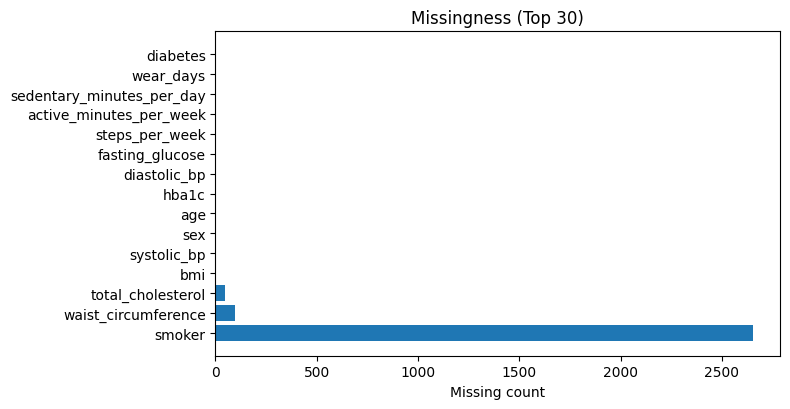

In [ ]:
fig = plt.figure(figsize=(8, max(3, 0.28*min(30, len(missing_df)))))
plt.barh(missing_df["column"].head(30), missing_df["n_missing"].head(30))
plt.xlabel("Missing count"); plt.title("Missingness (Top 30)"); plt.tight_layout()
save_and_show(fig, OUT_DIR / "eda_missingness.png")

In [ ]:
# Class balance
title_block("CLASS BALANCE")
cls = df[TARGET].value_counts().sort_index()
class_df = pd.DataFrame({"diabetes": cls.index, "count": cls.values})
class_df["percent"] = (class_df["count"]/len(df)*100).round(2)
display(class_df)
class_df.to_csv(OUT_DIR / "eda_class_balance.csv", index=False)


CLASS BALANCE


,diabetes,count,percent
0,0,3754,82.91
1,1,774,17.09


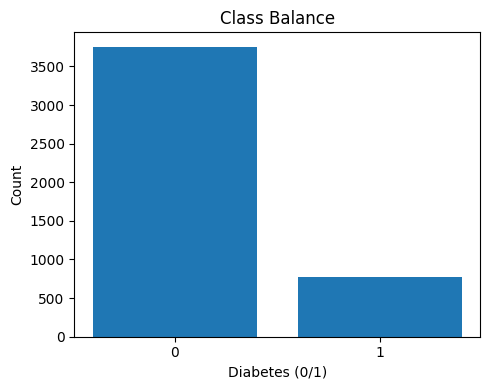

In [ ]:
fig = plt.figure(figsize=(5,4))
plt.bar(class_df["diabetes"].astype(str), class_df["count"])
plt.xlabel("Diabetes (0/1)"); plt.ylabel("Count"); plt.title("Class Balance"); plt.tight_layout()
save_and_show(fig, OUT_DIR / "eda_class_balance.png")

In [ ]:
# Grouped stats
title_block("GROUPED STATS BY DIABETES")
grouped = df.groupby(TARGET)[NUMERIC].agg(["mean","std","median"])
display(grouped.head(20))
grouped.to_csv(OUT_DIR / "eda_grouped_by_diabetes.csv")


GROUPED STATS BY DIABETES


age                          bmi                   \
               mean        std median       mean       std median   
diabetes                                                            
0         45.058871  18.031547   43.0  28.111588  6.661557   27.1   
1         60.733850  13.658521   62.0  32.287726  7.615971   30.8   

         waist_circumference                   systolic_bp  ...  \
                        mean        std median        mean  ...   
diabetes                                                    ...   
0                  96.159132  15.841950   94.8  120.205470  ...   
1                 108.938019  16.599096  106.6  131.769595  ...   

         steps_per_week active_minutes_per_week                       \
                 median                    mean        std    median   
diabetes                                                               
0          68429.277778                8.343352  20.887410  0.777778   
1          55955.277778                5.166232  24.646278  0.000000   

         sedentary_minutes_per_day                        wear_days            \
                              mean       std       median      mean       std   
diabetes                                                                        
0                      1378.840058  3.301124  1379.888889  8.865743  0.791026   
1                      1379.261967  3.520897  1380.000000  8.883721  0.726094   

                 
         median  
diabetes         
0           9.0  
1           9.0  

[2 rows x 39 columns]

In [ ]:
# Correlations
title_block("CORRELATIONS (NUMERIC)")
corr = df[NUMERIC].corr(numeric_only=True)
display(corr)
corr.to_csv(OUT_DIR / "eda_corr.csv")


CORRELATIONS (NUMERIC)


,age,bmi,waist_circumference,systolic_bp,diastolic_bp,hba1c,fasting_glucose,total_cholesterol,smoker,steps_per_week,active_minutes_per_week,sedentary_minutes_per_day,wear_days
age,1.000000,0.080056,0.241053,0.436298,-0.011207,0.295025,0.247095,0.141427,-0.370290,-0.176684,-0.049281,0.049073,0.005335
bmi,0.080056,1.000000,0.909891,0.157368,0.126712,0.217701,0.207039,0.040673,-0.093012,-0.128715,-0.151141,0.149527,-0.005963
waist_circumference,0.241053,0.909891,1.000000,0.220249,0.137647,0.279757,0.276736,0.061214,-0.144882,-0.175470,-0.143863,0.145739,-0.008595
systolic_bp,0.436298,0.157368,0.220249,1.000000,0.316753,0.222306,0.204681,0.121521,-0.074503,-0.086709,-0.047401,0.040862,0.010249
diastolic_bp,-0.011207,0.126712,0.137647,0.316753,1.000000,0.029694,0.036202,0.163460,0.024315,0.068648,0.024450,-0.029590,0.013917
hba1c,0.295025,0.217701,0.279757,0.222306,0.029694,1.000000,0.814377,0.061941,-0.077832,-0.091533,-0.078815,0.069922,0.003894
fasting_glucose,0.247095,0.207039,0.276736,0.204681,0.036202,0.814377,1.000000,0.036582,-0.080873,-0.106425,-0.060427,0.054022,0.010871
total_cholesterol,0.141427,0.040673,0.061214,0.121521,0.163460,0.061941,0.036582,1.000000,0.026077,0.039039,-0.022492,0.019886,0.005838
smoker,-0.370290,-0.093012,-0.144882,-0.074503,0.024315,-0.077832,-0.080873,0.026077,1.000000,0.050581,-0.006816,0.015792,0.005244
steps_per_week,-0.176684,-0.128715,-0.175470,-0.086709,0.068648,-0.091533,-0.106425,0.039039,0.050581,1.000000,0.229779,-0.232353,-0.005703


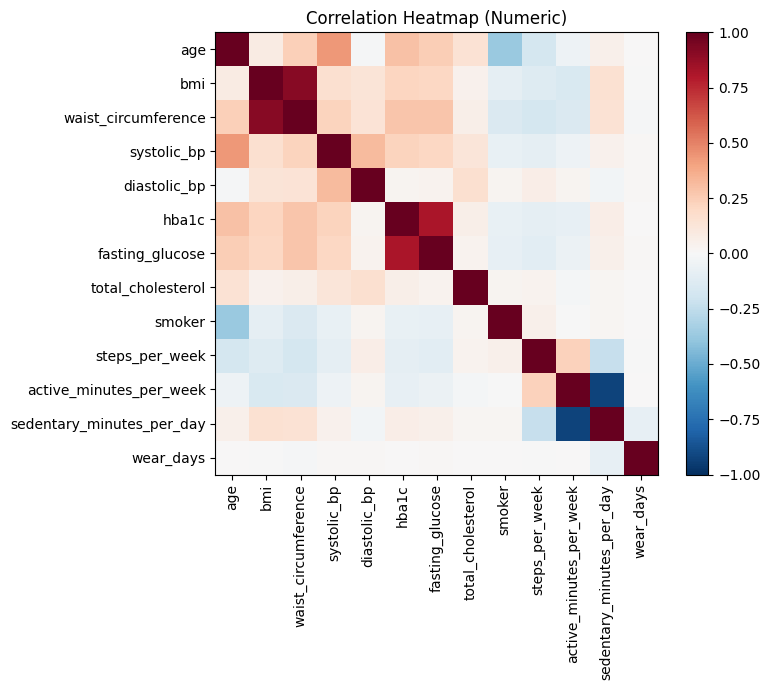

In [ ]:
fig = plt.figure(figsize=(9,7))
im = plt.imshow(corr, cmap="RdBu_r", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(NUMERIC)), NUMERIC, rotation=90)
plt.yticks(range(len(NUMERIC)), NUMERIC)
plt.title("Correlation Heatmap (Numeric)"); plt.tight_layout()
save_and_show(fig, OUT_DIR / "eda_corr_heatmap.png")


In [ ]:
# Univariate AUCs
title_block("UNIVARIATE AUCs (NUMERIC)")
rows = []; y = df[TARGET].astype(int).values
for col in NUMERIC:
    x = pd.to_numeric(df[col], errors="coerce").values
    m = ~np.isnan(x)
    if m.sum()>30 and len(np.unique(y[m]))==2 and len(np.unique(x[m]))>2:
        from sklearn.metrics import roc_auc_score
        try: auc = roc_auc_score(y[m], x[m])
        except Exception: auc = np.nan
    else: auc = np.nan
    rows.append({"feature": col, "univariate_auc": auc})
auc_df = pd.DataFrame(rows).sort_values("univariate_auc", ascending=False)
display(auc_df.head(20))
auc_df.to_csv(OUT_DIR / "eda_univariate_auc.csv", index=False)


UNIVARIATE AUCs (NUMERIC)


,feature,univariate_auc
5,hba1c,0.935939
6,fasting_glucose,0.920584
0,age,0.747929
2,waist_circumference,0.718648
3,systolic_bp,0.684734
1,bmi,0.672296
11,sedentary_minutes_per_day,0.618763
4,diastolic_bp,0.522110
12,wear_days,0.503020
7,total_cholesterol,0.454261



HISTOGRAMS BY CLASS (NUMERIC)


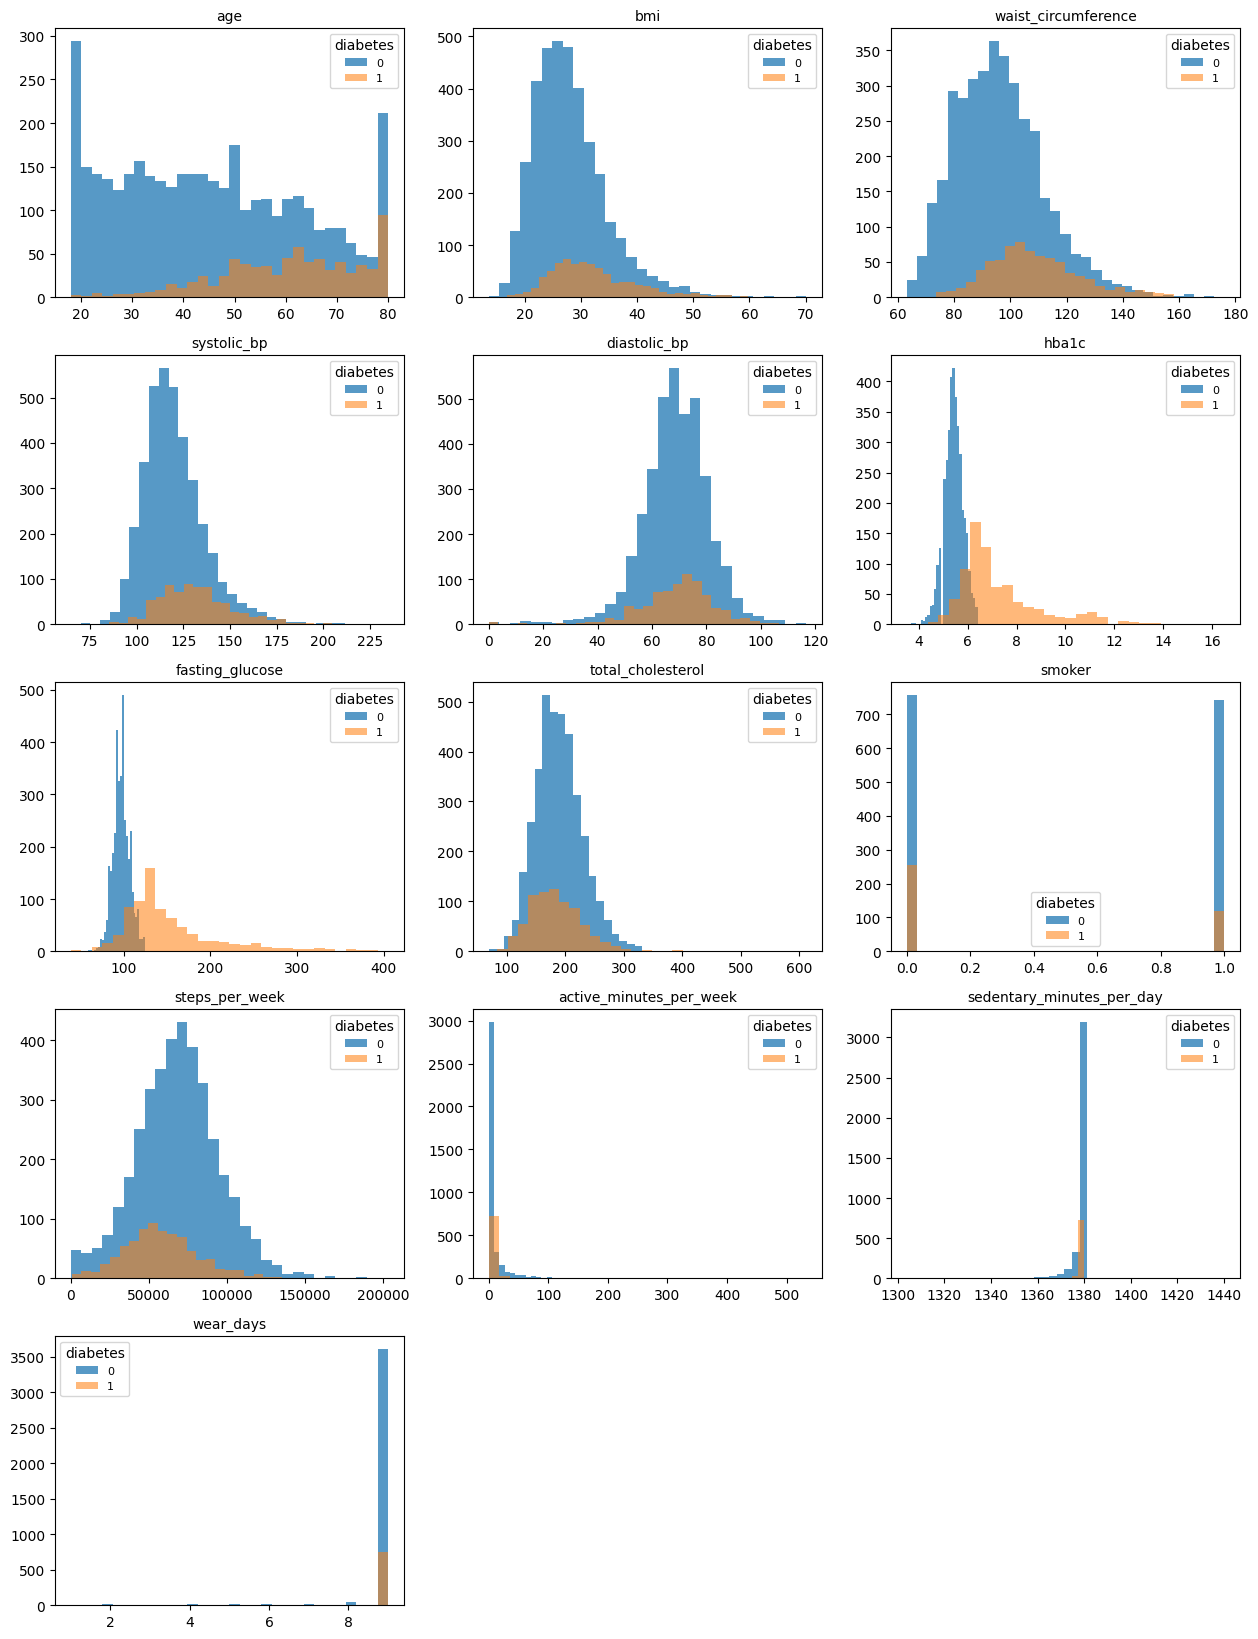

In [ ]:
# Histograms by class
title_block("HISTOGRAMS BY CLASS (NUMERIC)")
n=len(NUMERIC); cols=3; rows=max(1, int(np.ceil(n/cols)))
fig = plt.figure(figsize=(cols*4.2, rows*3.3))
for i, col in enumerate(NUMERIC, 1):
    ax = plt.subplot(rows, cols, i)
    for lab, alpha in [(0,0.75),(1,0.55)]:
        data = df.loc[df[TARGET]==lab, col].dropna()
        ax.hist(data, bins=30, alpha=alpha, label=str(lab))
    ax.set_title(col, fontsize=10); ax.legend(title=TARGET, fontsize=8)
plt.tight_layout()
save_and_show(fig, OUT_DIR / "eda_histograms.png")


BOXPLOTS BY LABEL (NUMERIC)


/tmp/ipython-input-2140360930.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([vals0, vals1], labels=["0","1"], showfliers=False)
/tmp/ipython-input-2140360930.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([vals0, vals1], labels=["0","1"], showfliers=False)
/tmp/ipython-input-2140360930.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([vals0, vals1], labels=["0","1"], showfliers=False)
/tmp/ipython-input-2140360930.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dr

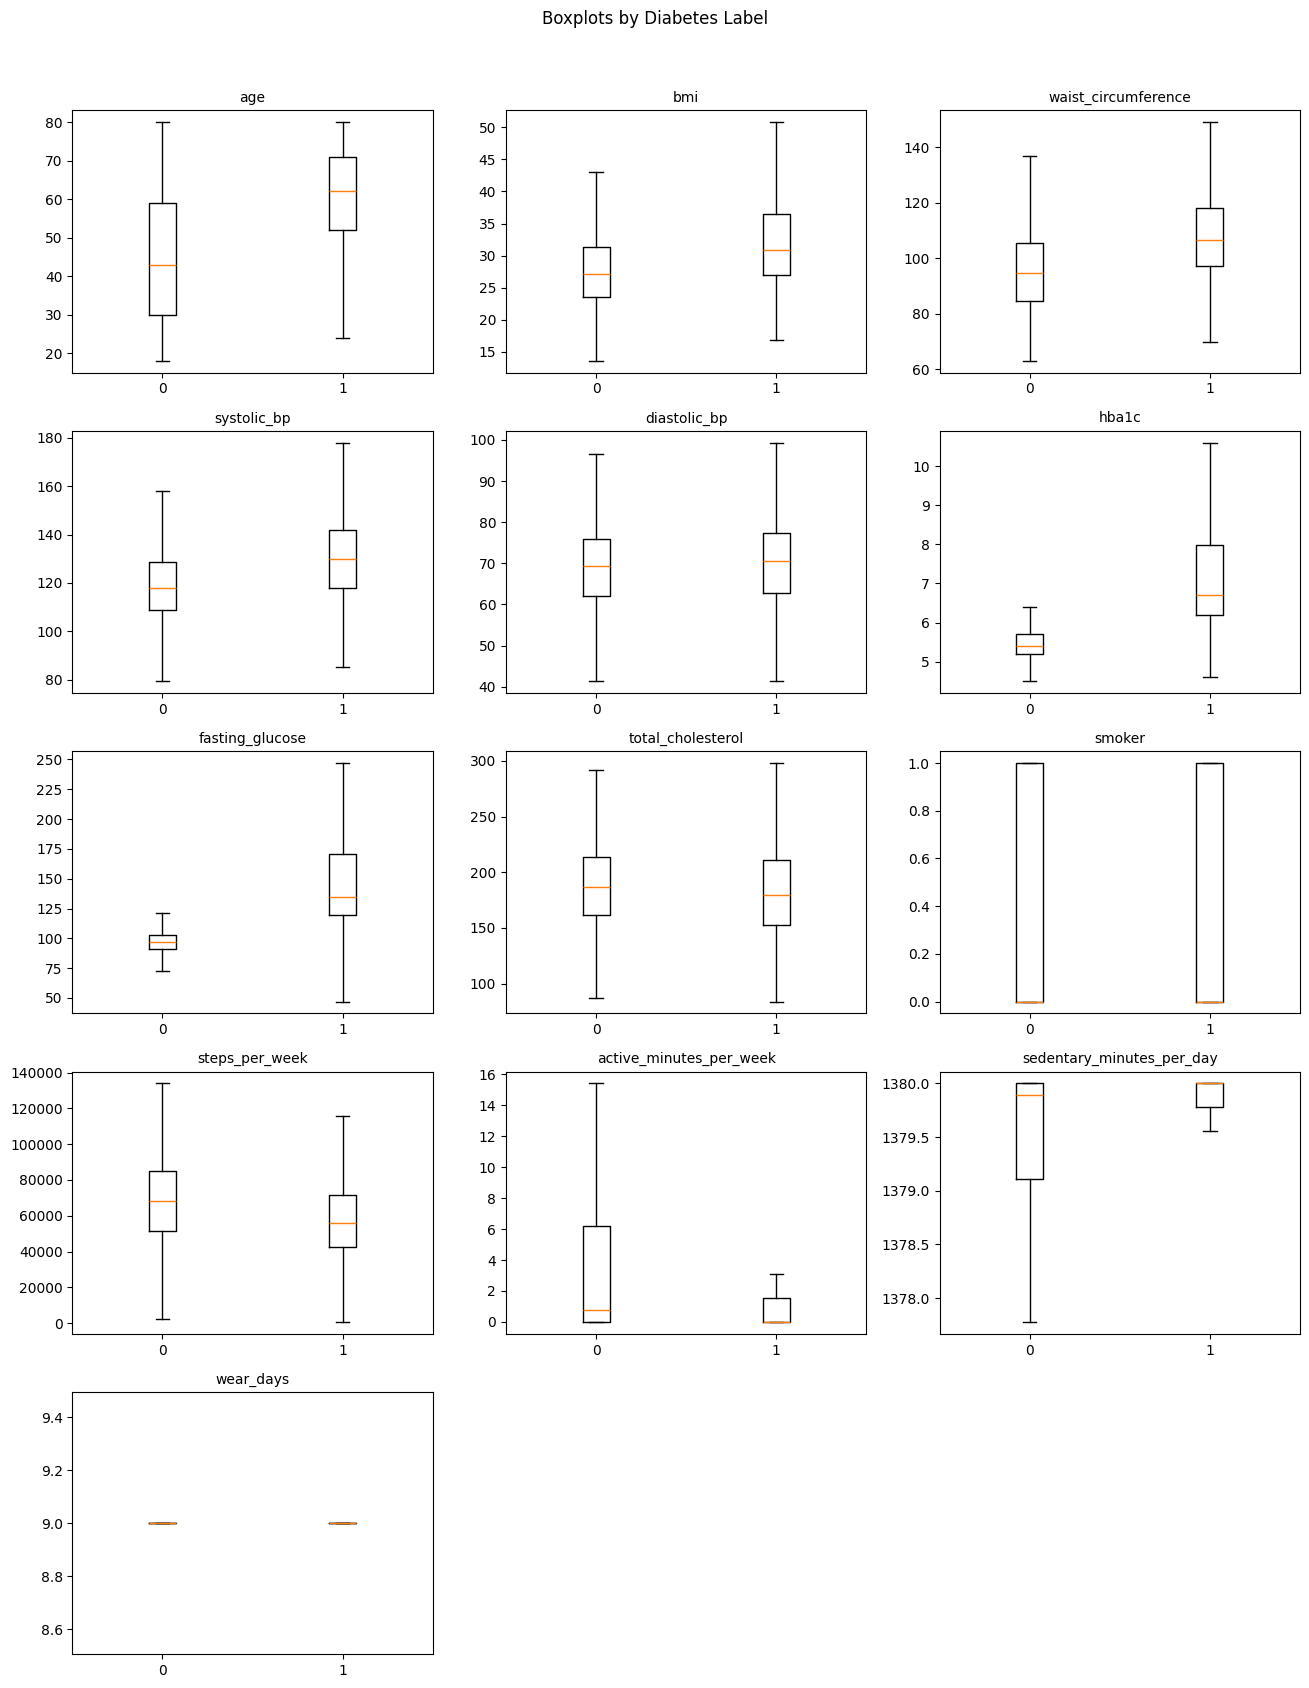

In [ ]:
# Boxplots by label
title_block("BOXPLOTS BY LABEL (NUMERIC)")
fig = plt.figure(figsize=(cols*4.4, rows*3.3))
for i, col in enumerate(NUMERIC, 1):
    ax = plt.subplot(rows, cols, i)
    vals0 = df.loc[df[TARGET]==0, col].dropna().values
    vals1 = df.loc[df[TARGET]==1, col].dropna().values
    if len(vals0) and len(vals1):
        ax.boxplot([vals0, vals1], labels=["0","1"], showfliers=False)
    ax.set_title(col, fontsize=10)
plt.suptitle("Boxplots by Diabetes Label", y=1.02)
plt.tight_layout()
save_and_show(fig, OUT_DIR / "eda_boxplots_by_label.png")

In [ ]:
print("\n[EDA DONE] Outputs in:", OUT_DIR)



[EDA DONE] Outputs in: /content/drive/MyDrive/Project/data


3) Modeling: preprocessing, SMOTE-in-CV, feature selection, eval, calibration, fixed PI & PDP, SHAP, save model

In [ ]:
# ===== Modeling & XAI =====
import warnings, json
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve,
                             average_precision_score, confusion_matrix,
                             classification_report, brier_score_loss)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.calibration import calibration_curve
import joblib

In [ ]:
# Optional packages
HAS_IMBLEARN = True
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
except Exception:
    HAS_IMBLEARN = False
    warnings.warn("imbalanced-learn not found — SMOTE will be skipped.")
HAS_SHAP = True
try:
    import shap  # noqa
except Exception:
    HAS_SHAP = False
    warnings.warn("shap not found — SHAP plots will be skipped.")

In [ ]:
# Config
RANDOM_SEED, N_TREES, N_FOLDS = 42, 400, 5
TOP_PDP, SHAP_SAMPLES = 4, 300

In [ ]:
# Load prepared dataset
df = pd.read_csv(OUT_DIR / "diabetes_sensor_train.csv")
TARGET = "diabetes"
CATEG  = ["sex"]
NUMERIC = [
    "age","bmi","waist_circumference","systolic_bp","diastolic_bp",
    "hba1c","fasting_glucose","total_cholesterol","smoker",
    "steps_per_week","active_minutes_per_week","sedentary_minutes_per_day","wear_days",
]
NUMERIC = [c for c in NUMERIC if c in df.columns]

X = df[NUMERIC + CATEG].copy()
y = df[TARGET].astype(int).copy()
print(f"[DATA] N={len(df):,} | Pos rate={y.mean()*100:.2f}%")

[DATA] N=4,528 | Pos rate=17.09%


In [ ]:
# Feature Engineering
ENGINEERED = [
    "pulse_pressure","map_mean_arterial_pressure","glyco_glu_product",
    "steps_per_wear_day","mvpa_per_wear_day","sedentary_ratio",
    "bmi_age_interaction","steps_per_bmi",
]
NUMERIC_ALL = NUMERIC + ENGINEERED

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self): self.feature_names_out_ = None
    def fit(self, X, y=None):
        self.feature_names_out_ = list(X.columns) + ENGINEERED; return self
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_out_[:X.shape[1]])
        df_ = X.copy()
        def sdiv(a,b,eps=1e-6): return a/np.maximum(b,eps)
        sbp=pd.to_numeric(df_.get("systolic_bp"),errors="coerce")
        dbp=pd.to_numeric(df_.get("diastolic_bp"),errors="coerce")
        hba=pd.to_numeric(df_.get("hba1c"),errors="coerce")
        glu=pd.to_numeric(df_.get("fasting_glucose"),errors="coerce")
        stp=pd.to_numeric(df_.get("steps_per_week"),errors="coerce")
        mv =pd.to_numeric(df_.get("active_minutes_per_week"),errors="coerce")
        sed=pd.to_numeric(df_.get("sedentary_minutes_per_day"),errors="coerce")
        wrd=pd.to_numeric(df_.get("wear_days"),errors="coerce")
        bmi=pd.to_numeric(df_.get("bmi"),errors="coerce")
        age=pd.to_numeric(df_.get("age"),errors="coerce")
        df_["pulse_pressure"]=sbp-dbp
        df_["map_mean_arterial_pressure"]=dbp+(sbp-dbp)/3.0
        df_["glyco_glu_product"]=hba*glu
        df_["steps_per_wear_day"]=sdiv(stp,wrd)
        df_["mvpa_per_wear_day"]=sdiv(mv,wrd)
        df_["sedentary_ratio"]=sdiv(sed,1440.0)
        df_["bmi_age_interaction"]=bmi*age
        df_["steps_per_bmi"]=sdiv(stp,bmi)
        return df_

In [ ]:
# Split
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)


In [ ]:
# Pipelines
fe = FeatureEngineer()
num_tf = SkPipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())])
cat_tf = SkPipeline([("imp", SimpleImputer(strategy="most_frequent")), ("oh", OneHotEncoder(handle_unknown="ignore"))])
pre = ColumnTransformer([("num", num_tf, NUMERIC_ALL), ("cat", cat_tf, CATEG)])
fs = SelectKBest(score_func=mutual_info_classif, k="all")
rf = RandomForestClassifier(n_estimators=N_TREES, random_state=RANDOM_SEED, class_weight="balanced", n_jobs=-1)

In [ ]:
Pipe = ImbPipeline if HAS_IMBLEARN else SkPipeline
pipe_base  = Pipe([("fe",fe),("pre",pre),("fs",fs),("clf",rf)])
pipe_smote = None
if HAS_IMBLEARN:
    smote = SMOTE(random_state=RANDOM_SEED)
    pipe_smote = ImbPipeline([("fe",fe),("pre",pre),("fs",fs),("smote",smote),("clf",rf)])

In [ ]:
grid = {"fs__k":["all",40,20],
        "clf__max_depth":[None,8,12],
        "clf__min_samples_split":[2,5],
        "clf__min_samples_leaf":[1,2]}

In [ ]:
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)


In [ ]:
def tune(name, pipe):
    if pipe is None: return None
    gs = GridSearchCV(pipe, grid, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True, verbose=0)
    gs.fit(Xtr, ytr)
    prob = gs.best_estimator_.predict_proba(Xte)[:,1]
    return {"name":name, "estimator":gs.best_estimator_, "probs":prob,
            "cv_auc":float(gs.best_score_),
            "val_auc":float(roc_auc_score(yte, prob)),
            "val_ap": float(average_precision_score(yte, prob)),
            "params":gs.best_params_}

In [ ]:
models = [m for m in [tune("rf_base", pipe_base), tune("rf_smote", pipe_smote)] if m]
best = sorted(models, key=lambda m:m["val_auc"], reverse=True)[0]
pipe, prob = best["estimator"], best["probs"]
print(f"\n[SELECT] Best: {best['name']} | Val AUC={best['val_auc']:.4f} | Val AP={best['val_ap']:.4f}")


[SELECT] Best: rf_base | Val AUC=0.9739 | Val AP=0.9417


In [ ]:
# Evaluation + figures
def youdens_j(y_true, y_prob):
    fpr, tpr, thr = roc_curve(y_true, y_prob); j = tpr-fpr; return float(thr[np.argmax(j)])

thr = youdens_j(yte, prob)
pred = (prob >= thr).astype(int)
auc  = roc_auc_score(yte, prob)
ap   = average_precision_score(yte, prob)
cm   = confusion_matrix(yte, pred)
report = classification_report(yte, pred, digits=4)
print(f"\n[AUC] {auc:.4f}  [AP] {ap:.4f}  [Thr@J] {thr:.3f}")
print("\n[CM @ Youden J]\n", cm)
print("\n[Report @ Youden J]\n", report)


[AUC] 0.9739  [AP] 0.9417  [Thr@J] 0.476

[CM @ Youden J]
 [[731  20]
 [ 19 136]]

[Report @ Youden J]
               precision    recall  f1-score   support

           0     0.9747    0.9734    0.9740       751
           1     0.8718    0.8774    0.8746       155

    accuracy                         0.9570       906
   macro avg     0.9232    0.9254    0.9243       906
weighted avg     0.9571    0.9570    0.9570       906



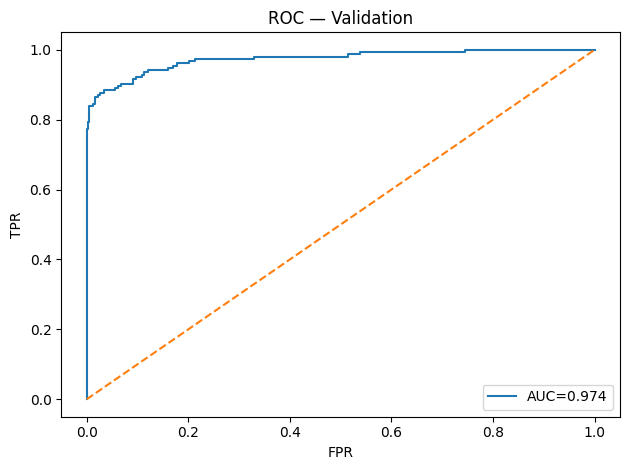

In [ ]:
# ROC
fpr, tpr, _ = roc_curve(yte, prob)
plt.figure(); plt.plot(fpr,tpr,label=f"AUC={auc:.3f}"); plt.plot([0,1],[0,1],'--')
plt.legend(); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC — Validation")
plt.tight_layout(); plt.savefig(OUT_DIR/"roc_curve.png",dpi=150); plt.show(); plt.close()


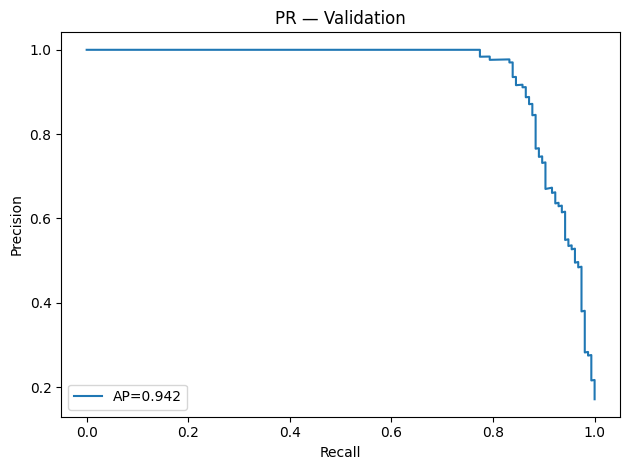

In [ ]:
# PR
prec, rec, _ = precision_recall_curve(yte, prob)
plt.figure(); plt.plot(rec,prec,label=f"AP={ap:.3f}")
plt.legend(loc="lower left"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR — Validation")
plt.tight_layout(); plt.savefig(OUT_DIR/"pr_curve.png",dpi=150); plt.show(); plt.close()


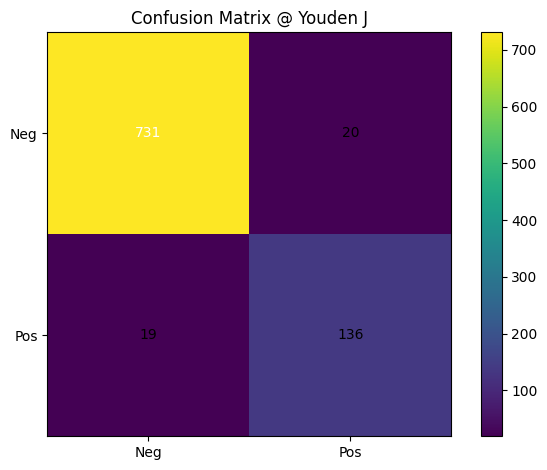

In [ ]:
# Confusion Matrix
plt.figure(); plt.imshow(cm, interpolation='nearest'); plt.title("Confusion Matrix @ Youden J"); plt.colorbar()
ticks=np.arange(2); plt.xticks(ticks,["Neg","Pos"]); plt.yticks(ticks,["Neg","Pos"])
m=cm.max()/2
for i in range(2):
    for j in range(2):
        plt.text(j,i,cm[i,j],ha='center',va='center',color="white" if cm[i,j]>m else "black")
plt.tight_layout(); plt.savefig(OUT_DIR/"confusion_matrix.png",dpi=150); plt.show(); plt.close()


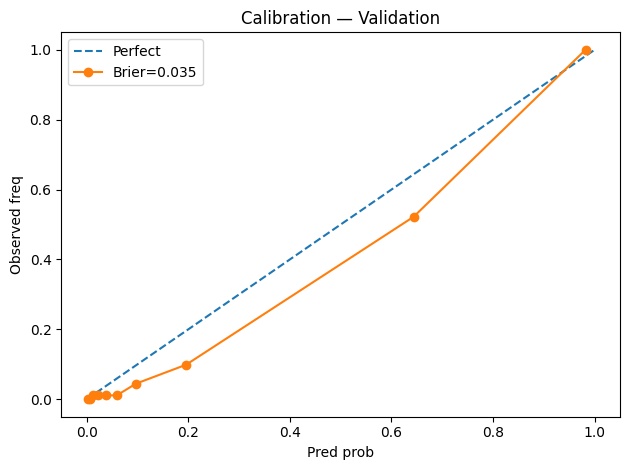

In [ ]:
# Calibration
pt, pp = calibration_curve(yte, prob, n_bins=10, strategy="quantile")
brier = brier_score_loss(yte, prob)
plt.figure(); plt.plot([0,1],[0,1],'--',label="Perfect"); plt.plot(pp,pt,'o-',label=f"Brier={brier:.3f}")
plt.legend(); plt.xlabel("Pred prob"); plt.ylabel("Observed freq"); plt.title("Calibration — Validation")
plt.tight_layout(); plt.savefig(OUT_DIR/"calibration_curve.png",dpi=150); plt.show(); plt.close()

pd.DataFrame(cm, index=["TrueNeg","TruePos"], columns=["PredNeg","PredPos"]).to_csv(OUT_DIR/"confusion_matrix.csv", index=True)

In [ ]:
# ===== Correct PERMUTATION IMPORTANCE (AFTER FE) =====
from sklearn.pipeline import Pipeline as _SkPipeline  # to build post-FE estimator

# Extract fitted steps
fe_step  = pipe.named_steps["fe"]
pre_step = pipe.named_steps["pre"]
fs_step  = pipe.named_steps.get("fs", None)
clf_step = pipe.named_steps["clf"]

In [ ]:
# FE-space data & names
Xte_fe = fe_step.transform(Xte)          # DataFrame (raw + engineered)
fe_feature_names = list(Xte_fe.columns)

In [ ]:
# Build post-FE estimator (pre -> fs? -> clf)
steps_post = [("pre", pre_step)]
if fs_step is not None:
    steps_post.append(("fs", fs_step))
steps_post.append(("clf", clf_step))
post_estimator = _SkPipeline(steps_post)


In [ ]:
# Permutation importance on FE-space
r = permutation_importance(post_estimator, Xte_fe, yte, n_repeats=5, random_state=RANDOM_SEED, n_jobs=-1)
importances = {name: float(r.importances_mean[i]) for i, name in enumerate(fe_feature_names)}


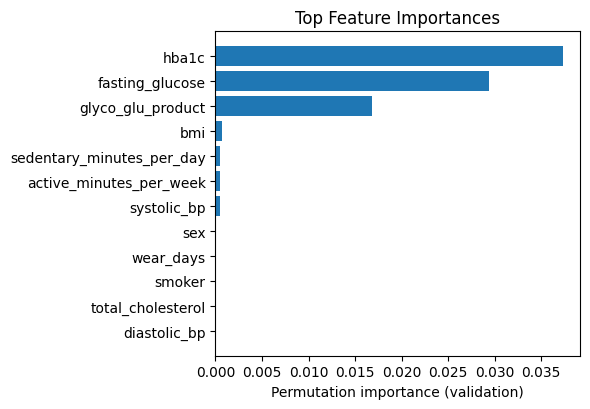

In [ ]:
# Plot Top-K
items = sorted(importances.items(), key=lambda kv: kv[1])[-12:]
plt.figure(figsize=(6, max(3, 0.35*len(items))))
plt.barh([k for k,_ in items], [v for _,v in items])
plt.xlabel("Permutation importance (validation)"); plt.title("Top Feature Importances")
plt.tight_layout(); plt.savefig(OUT_DIR/"feature_importance.png", dpi=150); plt.show(); plt.close()


<Figure size 1000x800 with 0 Axes>

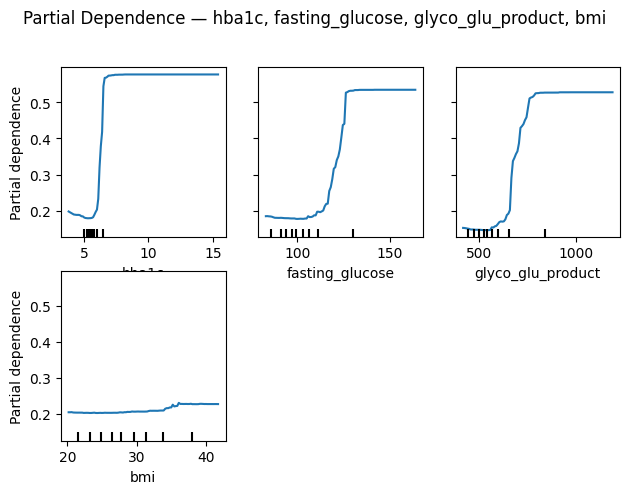

In [ ]:
# ===== PDP — engineered-aware (AFTER FE, by indices) =====
top_features = [k for k,_ in sorted(importances.items(), key=lambda kv: kv[1], reverse=True)]
pdp_candidate_names = [f for f in top_features if f in NUMERIC_ALL]  # numeric only

pdp_indices, display_names = [], []
for nm in pdp_candidate_names:
    try:
        idx = fe_feature_names.index(nm)
        pdp_indices.append(idx); display_names.append(nm)
    except ValueError:
        pass
    if len(pdp_indices) >= TOP_PDP:
        break

if pdp_indices:
    plt.figure(figsize=(10, 8))
    PartialDependenceDisplay.from_estimator(
        post_estimator,  # consumes FE-space
        Xte_fe,
        features=pdp_indices,
        kind="average"
    )
    plt.suptitle("Partial Dependence — " + ", ".join(display_names), y=1.02)
    plt.tight_layout(); plt.savefig(OUT_DIR/"partial_dependence.png", dpi=150, bbox_inches="tight"); plt.show(); plt.close()
else:
    print("[PDP] Skipped — no numeric FE features to plot.")

<Figure size 640x480 with 0 Axes>

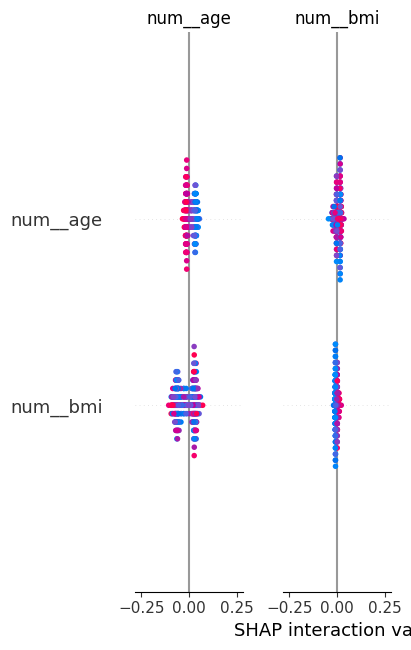

[SHAP] skipped: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 30


<Figure size 640x480 with 0 Axes>

In [ ]:
# ===== SHAP (optional) =====
if HAS_SHAP:
    try:
        Xte_fe2 = fe_step.transform(Xte)
        Xt = pre_step.transform(Xte_fe2)
        if fs_step is not None:
            Xt = fs_step.transform(Xt)
        try:
            feat_names = pre_step.get_feature_names_out(Xte_fe2.columns)
        except Exception:
            feat_names = [f"f{i}" for i in range(Xt.shape[1])]
        if fs_step is not None and getattr(fs_step,"get_support",None):
            supp = fs_step.get_support()
            if supp is not None and len(supp)==len(feat_names):
                feat_names = [n for n,k in zip(feat_names, supp) if k]
        if hasattr(Xt,"toarray"): Xt = Xt.toarray()
        n = min(SHAP_SAMPLES, Xt.shape[0]); idx = np.random.RandomState(RANDOM_SEED).choice(Xt.shape[0], n, replace=False)
        Xs = Xt[idx,:]
        model = pipe.named_steps["clf"]; ex = shap.TreeExplainer(model)
        sv = ex.shap_values(Xs); sv = sv[1] if isinstance(sv,list) else sv

        plt.figure(); shap.summary_plot(sv, Xs, feature_names=feat_names, show=False)
        plt.tight_layout(); plt.savefig(OUT_DIR/"shap_summary.png", dpi=150, bbox_inches="tight"); plt.show(); plt.close()

        top_feat = top_features[0] if top_features else None
        if top_feat:
            matches = [i for i,nm in enumerate(feat_names) if top_feat in nm]
            if matches:
                plt.figure(); shap.dependence_plot(matches[0], sv, Xs, feature_names=feat_names, show=False)
                plt.tight_layout(); plt.savefig(OUT_DIR/"shap_dependence.png", dpi=150, bbox_inches="tight"); plt.show(); plt.close()
    except Exception as e:
        print("[SHAP] skipped:", e)
else:
    print("[SHAP] shap not installed — skipped.")

In [ ]:
# Save metrics & model artifact
with open(OUT_DIR/"metrics.json","w") as f:
    json.dump({
        "auc":float(auc),"average_precision":float(ap),"threshold_youden_j":float(thr),
        "brier_score":float(brier),"confusion_matrix":cm.tolist(),
        "classification_report":report,"winner":best["name"],
        "top_features": top_features[:12],
    }, f, indent=2)

artifact = {"pipeline":pipe, "threshold":float(thr),
            "numeric_features": NUMERIC_ALL,
            "categorical_features": CATEG,
            "engineered_features": ENGINEERED,
            "target":"diabetes",
            "auc":float(auc), "average_precision":float(ap),
            "feature_importance": importances}
joblib.dump(artifact, MODELS_DIR/"diabetes_pipeline_sensor.joblib")

print("\n[SAVED] Figures & metrics →", OUT_DIR)
print("[SAVED] Model →", MODELS_DIR/"diabetes_pipeline_sensor.joblib")


[SAVED] Figures & metrics → /content/drive/MyDrive/Project/data
[SAVED] Model → /content/drive/MyDrive/Project/models/diabetes_pipeline_sensor.joblib
